In [1]:
# Importing core libraries
import seaborn as sns
import scipy.stats as ss
import math 
import numpy as np
import pandas as pd
import pprint
import joblib

from collections import Counter
from time import time
from matplotlib import pyplot as plt
from scipy import stats
# Classifiers
from catboost import CatBoostClassifier, Pool

# Model selection
from sklearn.model_selection import StratifiedKFold

# Metrics
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import make_scorer

## Reading the Data and Preprocessing

In [2]:
df_train = pd.read_csv('../input/bri-data-hackathon-pa/train.csv')
df_test = pd.read_csv('../input/bri-data-hackathon-pa/test.csv')
sample_submission = pd.read_csv('../input/bri-data-hackathon-pa/sample_submission.csv')

#df_train = df_train.drop(['age','year_graduated'],axis=1)
#df_test = df_test.drop(['age','year_graduated'],axis=1)

In [3]:
pd.set_option("display.max_columns", None)

df_train

,job_level,job_duration_in_current_job_level,person_level,job_duration_in_current_person_level,job_duration_in_current_branch,Employee_type,gender,age,marital_status_maried(Y/N),number_of_dependences,Education_level,GPA,year_graduated,job_duration_from_training,branch_rotation,job_rotation,assign_of_otherposition,annual leave,sick_leaves,Last_achievement_%,Achievement_above_100%_during3quartal,Best Performance
0,JG04,1.352775,PG03,1.352775,1.732051,RM_type_A,2,1985,Y,1,level_0,2.86,2011,4,2,3,2,3,0,46.37,0.0,0
1,JG04,1.292285,PG03,1.292285,1.039230,RM_type_A,2,1989,Y,0,level_1,7.28,2007,4,4,3,0,0,1,47.68,0.0,0
2,JG05,2.565151,PG06,2.308679,1.780449,RM_type_C,1,1970,Y,1,level_1,0.00,1989,28,10,9,6,2,1,40.73,0.0,0
3,JG05,2.828427,PG06,1.000000,1.385641,RM_type_A,2,1967,Y,2,level_1,0.00,1987,29,11,6,0,4,10,47.42,0.0,1
4,JG05,2.828427,PG06,2.828427,0.707107,RM_type_A,2,1965,Y,3,level_1,7.20,1985,30,9,8,2,3,0,47.18,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11148,JG04,1.256981,PG03,1.256981,1.224745,RM_type_A,2,1986,Y,1,level_5,3.33,2016,4,3,3,0,4,1,50.87,0.0,0
11149,JG04,1.385641,PG03,1.385641,1.802776,RM_type_B,1,1988,Y,2,level_5,3.00,2015,3,1,2,0,6,0,79.91,0.0,0
11150,JG04,1.256981,PG03,1.256981,1.385641,RM_type_B,2,1991,Y,0,level_5,3.48,2017,2,1,2,0,4,0,78.38,0.0,0
11151,JG04,1.118034,PG03,1.118034,0.000000,RM_type_A,1,1987,Y,1,level_5,3.53,2012,5,5,4,0,4,1,85.94,1.0,0


In [4]:
df_test

,job_level,job_duration_in_current_job_level,person_level,job_duration_in_current_person_level,job_duration_in_current_branch,Employee_type,gender,age,marital_status_maried(Y/N),number_of_dependences,Education_level,GPA,year_graduated,job_duration_from_training,branch_rotation,job_rotation,assign_of_otherposition,annual leave,sick_leaves,Last_achievement_%,Achievement_above_100%_during3quartal
0,JG04,1.256981,PG03,1.256981,0.707107,RM_type_A,1,1988,N,0,level_3,3.08,2009,6,4,2,6,3,7,84.02,0.0
1,JG04,1.224745,PG03,1.224745,1.256981,RM_type_B,2,1991,N,0,level_4,3.31,2014,2,2,2,0,1,0,63.74,0.0
2,JG04,0.500000,PG03,0.500000,1.081665,RM_type_A,2,1989,Y,1,level_4,3.44,2011,4,2,2,0,2,1,88.19,1.0
3,JG04,1.256981,PG03,1.256981,1.802776,RM_type_A,2,1990,Y,1,level_4,0.00,2014,3,1,3,0,3,0,25.94,0.0
4,JG04,1.352775,PG03,1.352775,1.224745,RM_type_B,1,1985,Y,0,level_4,3.34,2007,5,3,2,0,3,0,82.32,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,JG04,1.292285,PG03,1.292285,0.707107,RM_type_B,2,1988,Y,0,level_4,3.01,2015,2,2,2,0,4,0,58.60,0.0
5996,JG04,1.352775,PG03,1.352775,1.581139,RM_type_A,2,1989,Y,1,level_4,3.56,2011,5,3,2,7,3,0,90.64,3.0
5997,JG04,1.385641,PG03,1.385641,1.224745,RM_type_A,2,1991,Y,0,level_4,3.59,2013,3,2,3,0,16,0,13.02,0.0
5998,JG05,1.385641,PG05,1.385641,0.648074,RM_type_A,2,1980,Y,2,level_4,2.93,2003,14,7,6,8,2,0,82.26,0.0


In [5]:
df_train.job_duration_in_current_job_level.isin(df_train.job_duration_in_current_person_level).value_counts()

True     10981
False      172
Name: job_duration_in_current_job_level, dtype: int64

In [6]:
df_test.job_duration_in_current_job_level.isin(df_test.job_duration_in_current_person_level).value_counts()

True     5855
False     145
Name: job_duration_in_current_job_level, dtype: int64

In [7]:
df_train = df_train.drop(['job_duration_in_current_person_level'], axis=1)
df_test = df_test.drop(['job_duration_in_current_person_level'], axis=1)

In [8]:
df_train['rotation'] = (df_train['branch_rotation'] + df_train['job_rotation'] + df_train['assign_of_otherposition'])/3
df_test['rotation'] = (df_test['branch_rotation'] + df_test['job_rotation'] + df_test['assign_of_otherposition'])/3

In [9]:
df_train['age_year_graduated'] = df_train['year_graduated'] - df_train['age']
df_test['age_year_graduated'] = df_test['year_graduated'] - df_test['age']

In [10]:
df_train.loc[(df_train['Education_level']=='level_1')]

,job_level,job_duration_in_current_job_level,person_level,job_duration_in_current_branch,Employee_type,gender,age,marital_status_maried(Y/N),number_of_dependences,Education_level,GPA,year_graduated,job_duration_from_training,branch_rotation,job_rotation,assign_of_otherposition,annual leave,sick_leaves,Last_achievement_%,Achievement_above_100%_during3quartal,Best Performance,rotation,age_year_graduated
1,JG04,1.292285,PG03,1.039230,RM_type_A,2,1989,Y,0,level_1,7.28,2007,4,4,3,0,0,1,47.68,0.0,0,2.333333,18
2,JG05,2.565151,PG06,1.780449,RM_type_C,1,1970,Y,1,level_1,0.00,1989,28,10,9,6,2,1,40.73,0.0,0,8.333333,19
3,JG05,2.828427,PG06,1.385641,RM_type_A,2,1967,Y,2,level_1,0.00,1987,29,11,6,0,4,10,47.42,0.0,1,5.666667,20
4,JG05,2.828427,PG06,0.707107,RM_type_A,2,1965,Y,3,level_1,7.20,1985,30,9,8,2,3,0,47.18,0.0,0,6.333333,20
5,JG05,2.828427,PG06,1.118034,RM_type_A,1,1971,Y,3,level_1,0.00,1990,28,7,9,4,0,0,48.46,0.0,0,6.666667,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,JG05,2.828427,PG07,1.581139,RM_type_A,1,1966,Y,3,level_1,0.00,1984,31,8,6,2,0,0,87.41,1.0,0,5.333333,18
137,JG05,2.858321,PG06,0.707107,RM_type_A,1,1966,Y,2,level_1,0.00,1986,31,13,9,0,0,0,64.19,0.0,1,7.333333,20
138,JG05,2.828427,PG06,0.707107,RM_type_A,1,1973,Y,1,level_1,13.43,1991,24,10,9,1,11,4,93.77,2.0,0,6.666667,18
139,JG05,2.828427,PG06,0.707107,RM_type_A,1,1970,Y,1,level_1,0.00,1989,27,15,8,0,2,1,75.70,0.0,0,7.666667,19


In [11]:
#df_train.loc[(df_train['Education_level']=='level_1')]
df_train.loc[(df_train['Education_level']=='level_2')].head()
#kok urut indexnya wkwkwk lmao????????????????

,job_level,job_duration_in_current_job_level,person_level,job_duration_in_current_branch,Employee_type,gender,age,marital_status_maried(Y/N),number_of_dependences,Education_level,GPA,year_graduated,job_duration_from_training,branch_rotation,job_rotation,assign_of_otherposition,annual leave,sick_leaves,Last_achievement_%,Achievement_above_100%_during3quartal,Best Performance,rotation,age_year_graduated
141,JG04,1.118034,PG03,0.707107,RM_type_B,1,1995,Y,1,level_2,0.00,2014,3,2,2,1,3,1,23.77,0.0,0,1.666667,19
142,JG04,1.292285,PG03,0.707107,RM_type_B,2,1988,Y,1,level_2,3.01,2010,4,3,3,0,3,3,70.29,0.0,0,2.000000,22
143,JG04,2.828427,PG04,0.707107,RM_type_A,1,1972,Y,2,level_2,0.00,2003,24,9,7,0,2,1,63.95,0.0,0,5.333333,31
144,JG04,2.828427,PG04,1.000000,RM_type_A,2,1978,Y,2,level_2,3.01,1998,18,8,7,4,4,0,78.54,0.0,0,6.333333,20


In [12]:
#drop education level
df_train = df_train.drop(['Education_level'], axis=1)
df_test = df_test.drop(['Education_level'], axis=1)

In [13]:
numbers = df_train.age
age_numbers = [2020 - number for number in numbers]
df_train.age = age_numbers

num = df_test.age
age_num = [2020 - x for x in num]
df_test.age = age_num

In [14]:
numbers1 = df_train.year_graduated
age_numbers1 = [2020 - number for number in numbers1]
df_train.year_graduated = age_numbers1

num1 = df_test.year_graduated
age_num1 = [2020 - x for x in num1]
df_test.year_graduated = age_num1

In [15]:
#change GPA 4.1-41 Train
column_name = 'GPA'

mask1 = (df_train.GPA >= 4.1) & (df_train.GPA <= 41)
df_train.loc[mask1, column_name] = df_train.GPA / 10

#change GPA 41-410 Train

mask2 = (df_train.GPA >= 41) & (df_train.GPA <= 410)
df_train.loc[mask2, column_name] = df_train.GPA / 100

#change GPA 4.1-41 Test

mask3 = (df_test.GPA >= 4.1) & (df_test.GPA <= 41)
df_test.loc[mask3, column_name] = df_test.GPA / 10

#change GPA 41-410 Test

mask4 = (df_test.GPA >= 41) & (df_test.GPA <= 410)
df_test.loc[mask4, column_name] = df_test.GPA / 100

In [16]:
#df_train['Last_achievement_%'] = df_train['Last_achievement_%'] / 100
#df_test['Last_achievement_%'] = df_test['Last_achievement_%'] / 100

In [17]:
df_train['quantile_current_branch'] = pd.qcut(df_train['job_duration_in_current_branch'],
                              q=[0, .2, .4, .6, .8, 1],
                              labels=False,
                            duplicates='drop')
df_test['quantile_current_branch'] = pd.qcut(df_test['job_duration_in_current_branch'],
                              q=[0, .2, .4, .6, .8, 1],
                              labels=False,
                            duplicates='drop')

In [18]:
jblv1 = 'job_level'

filt = df_train[jblv1] == 'JG03'
df_train.loc[filt, jblv1] = 0

filt2 = (df_train[jblv1] == 'JG04')
df_train.loc[filt2, jblv1] = 1

filt3 = (df_train[jblv1] == 'JG05')
df_train.loc[filt3, jblv1] = 2

#test

j11 = 'job_level'

filt1 = df_test[j11] == 'JG03'
df_test.loc[filt1, j11] = 0

filt22 = (df_test[j11] == 'JG04')
df_test.loc[filt22, j11] = 1

filt33 = (df_test[j11] == 'JG05')
df_test.loc[filt33, j11] = 2

filt44 = (df_test[j11] == 'JG06')
df_test.loc[filt44, j11] = 2

In [19]:
perlv1 = 'person_level'

filt = df_train[perlv1] == 'PG01'
df_train.loc[filt, perlv1] = 0
filt2 = (df_train[perlv1] == 'PG02')
df_train.loc[filt2, perlv1] = 1
filt3 = (df_train[perlv1] == 'PG03')
df_train.loc[filt3, perlv1] = 2
filt4 = (df_train[perlv1] == 'PG04')
df_train.loc[filt4, perlv1] = 3
filt5 = (df_train[perlv1] == 'PG05')
df_train.loc[filt5, perlv1] = 4
filt6 = (df_train[perlv1] == 'PG06')
df_train.loc[filt6, perlv1] = 5
filt7 = (df_train[perlv1] == 'PG07')
df_train.loc[filt7, perlv1] = 6
filt8 = (df_train[perlv1] == 'PG08')
df_train.loc[filt8, perlv1] = 7

#test
filt = df_test[perlv1] == 'PG01'
df_test.loc[filt, perlv1] = 0
filt2 = (df_test[perlv1] == 'PG02')
df_test.loc[filt2, perlv1] = 1
filt3 = (df_test[perlv1] == 'PG03')
df_test.loc[filt3, perlv1] = 2
filt4 = (df_test[perlv1] == 'PG04')
df_test.loc[filt4, perlv1] = 3
filt5 = (df_test[perlv1] == 'PG05')
df_test.loc[filt5, perlv1] = 4
filt6 = (df_test[perlv1] == 'PG06')
df_test.loc[filt6, perlv1] = 5
filt7 = (df_test[perlv1] == 'PG07')
df_test.loc[filt7, perlv1] = 6
filt8 = (df_test[perlv1] == 'PG08')
df_test.loc[filt8, perlv1] = 7

In [20]:
emptype1 = 'Employee_type'

filt = df_train[emptype1] == 'RM_type_C'
df_train.loc[filt, emptype1] = 0

filt2 = (df_train[emptype1] == 'RM_type_B')
df_train.loc[filt2, emptype1] = 1

filt3 = (df_train[emptype1] == 'RM_type_A')
df_train.loc[filt3, emptype1] = 2

#test
filt = df_test[emptype1] == 'RM_type_C'
df_test.loc[filt, emptype1] = 0

filt2 = (df_test[emptype1] == 'RM_type_B')
df_test.loc[filt2, emptype1] = 1

filt3 = (df_test[emptype1] == 'RM_type_A')
df_test.loc[filt3, emptype1] = 2

In [21]:
mrtsts1 = 'marital_status_maried(Y/N)'

filt = df_train[mrtsts1] == 'Y'
df_train.loc[filt, mrtsts1] = 1

filt2 = (df_train[mrtsts1] == 'N')
df_train.loc[filt2, mrtsts1] = 0

filt = df_test[mrtsts1] == 'Y'
df_test.loc[filt, mrtsts1] = 1

filt2 = (df_test[mrtsts1] == 'N')
df_test.loc[filt2, mrtsts1] = 0


In [22]:
#df_features
binary_var = ['gender','marital_status_maried(Y/N)']
nominal = ['age','year_graduated',
           'job_duration_in_current_job_level',
           #'job_duration_in_current_person_level',
           'job_duration_in_current_branch',           
           'GPA',
           'job_duration_from_training',
           'branch_rotation',
           'job_rotation',
           'assign_of_otherposition',
           'number_of_dependences',
           'annual leave',
           'sick_leaves',
           'Last_achievement_%',
           'Achievement_above_100%_during3quartal',
           'rotation',
           'age_year_graduated',
          ]
ordinal = ['job_level',
           'person_level',
           'Employee_type',           
           #'Education_level',
          ]
cols = binary_var + nominal + ordinal

In [23]:
y = df_train['Best Performance'].values
X = df_train[cols]
Xt = df_test[cols]

In [24]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11153 entries, 0 to 11152
Data columns (total 21 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   gender                                 11153 non-null  int64  
 1   marital_status_maried(Y/N)             11153 non-null  object 
 2   age                                    11153 non-null  int64  
 3   year_graduated                         11153 non-null  int64  
 4   job_duration_in_current_job_level      11153 non-null  float64
 5   job_duration_in_current_branch         11153 non-null  float64
 6   GPA                                    11153 non-null  float64
 7   job_duration_from_training             11153 non-null  int64  
 8   branch_rotation                        11153 non-null  int64  
 9   job_rotation                           11153 non-null  int64  
 10  assign_of_otherposition                11153 non-null  int64  
 11  nu

# **Scaling**

In [25]:
from sklearn.preprocessing import MinMaxScaler

# Min-max normalization
X[ordinal] = MinMaxScaler().fit_transform(X[ordinal])
Xt[ordinal] = MinMaxScaler().fit_transform(Xt[ordinal])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1737: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

In [26]:
X = X.fillna(-999)
Xt = Xt.fillna(-999)

#X = X.apply(lambda x: x.fillna(x.mean()),axis=0)
#Xt = Xt.apply(lambda x: x.fillna(x.mean()),axis=0)

# **LABELING**

In [27]:
from sklearn.preprocessing import LabelEncoder
for col in list(X):
    if X[col].dtype=='O':
        print(col)
        X[col] = X[col].fillna('unseen_before_label')
        Xt[col]  = Xt[col].fillna('unseen_before_label')
        
        X[col] = X[col].astype(str)
        Xt[col] = Xt[col].astype(str)
        
        le = LabelEncoder()
        le.fit(list(X[col])+list(Xt[col]))
        X[col] = le.transform(X[col])
        Xt[col]  = le.transform(Xt[col])
    
    elif col in nominal:
        X[col] = X[col].astype(float).fillna(-999)
        Xt[col]  = Xt[col].astype(float).fillna(-999)
        
        le = LabelEncoder()
        le.fit(list(X[col])+list(Xt[col]))
        X[col] = le.transform(X[col])
        Xt[col]  = le.transform(Xt[col])

In [28]:
X

,gender,marital_status_maried(Y/N),age,year_graduated,job_duration_in_current_job_level,job_duration_in_current_branch,GPA,job_duration_from_training,branch_rotation,job_rotation,assign_of_otherposition,number_of_dependences,annual leave,sick_leaves,Last_achievement_%,Achievement_above_100%_during3quartal,rotation,age_year_graduated,job_level,person_level,Employee_type
0,2,1,12,9,22,36,104,2,1,2,2,1,3,0,1185,1,5,9,0.5,0.285714,1.0
1,2,1,8,13,20,13,24,2,3,2,0,0,0,1,1298,1,5,1,0.5,0.285714,1.0
2,1,1,27,31,79,38,0,24,9,8,6,1,2,1,747,1,23,2,1.0,0.714286,0.0
3,2,1,30,33,96,23,0,25,10,5,0,2,4,10,1275,1,15,3,1.0,0.714286,1.0
4,2,1,32,35,96,6,23,26,8,7,2,3,3,0,1254,1,17,3,1.0,0.714286,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11148,2,1,11,4,19,18,155,2,2,2,0,1,4,1,1574,1,4,13,0.5,0.285714,1.0
11149,1,1,9,5,23,39,118,1,0,1,0,2,6,0,4283,1,1,10,0.5,0.285714,0.5
11150,2,1,6,3,19,23,170,0,0,1,0,0,4,0,4142,1,1,9,0.5,0.285714,0.5
11151,1,1,10,8,15,0,175,3,4,3,0,1,4,1,4819,2,7,8,0.5,0.285714,1.0


# Transforming all the labels of all variables
from sklearn.preprocessing import LabelEncoder

label_encoders = [LabelEncoder() for _ in range(X.shape[1])]

for col, column in enumerate(X.columns):
    unique_values = pd.Series(X[column].append(Xt[column]).unique())
    unique_values = unique_values[unique_values.notnull()]
    label_encoders[col].fit(unique_values)
    X.loc[X[column].notnull(), column] = label_encoders[col].transform(X.loc[X[column].notnull(), column])
    Xt.loc[Xt[column].notnull(), column] = label_encoders[col].transform(Xt.loc[Xt[column].notnull(), column])

def frequency_encoding(column, df, df_test=None):
    frequencies = df[column].value_counts().reset_index()
    df_values = df[[column]].merge(frequencies, how='left', 
                                   left_on=column, right_on='index').iloc[:,-1].values
    if df_test is not None:
        df_test_values = df_test[[column]].merge(frequencies, how='left', 
                                                 left_on=column, right_on='index').fillna(1).iloc[:,-1].values
    else:
        df_test_values = None
    return df_values, df_test_values

for column in X.columns:
    train_values, test_values = frequency_encoding(column, X, Xt)
    X[column+'_freq'] = train_values
    Xt[column+'_freq'] = test_values

import category_encoders as cat_encode


enc_x = np.zeros(X[cols].shape)

for tr_idx, oof_idx in StratifiedKFold(n_splits=5, random_state=2021, shuffle=True).split(X, y):
    encoder = cat_encode.TargetEncoder(cols=cols, smoothing=1)
    
    encoder.fit(X[cols].iloc[tr_idx], y[tr_idx])
    enc_x[oof_idx, :] = encoder.transform(X[cols].iloc[oof_idx], y[oof_idx])
    
encoder.fit(X[cols], y)
enc_xt = encoder.transform(Xt[cols]).values

for idx, new_var in enumerate(cols):
    new_var = new_var + '_enc'
    X[new_var] = enc_x[:,idx]
    Xt[new_var] = enc_xt[:, idx]

In [29]:
feature_name = list(X.columns)
# no of maximum features we need to select
num_feats=20

# Set some Parameters

# 1. Pearson correlation

This is a filter-based method. 
We check the absolute value of the Pearson's correlation between the target and numerical features in our dataset. We keep the top n features based on this criterion.

In [30]:
def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature
cor_support, cor_feature = cor_selector(X, y,num_feats)
print(str(len(cor_feature)), 'selected features')

20 selected features


cor_feature

# 2. Chi-Square Features

This is another filter-based method. 
In this method, we calculate the chi-square metric between the target and the numerical variable and only select the variable with the maximum chi-squared values.

In [31]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=num_feats)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')

20 selected features


chi_feature

# 3. Recursive Feature Elimination

In [32]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=num_feats, step=10, verbose=5)
rfe_selector.fit(X_norm, y)

Fitting estimator with 21 features.


RFE(estimator=LogisticRegression(), n_features_to_select=20, step=10, verbose=5)

In [33]:
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

20 selected features


rfe_feature

# 4. Lasso: SelectFromModel

In [34]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2"), max_features=num_feats)
embeded_lr_selector.fit(X_norm, y)

SelectFromModel(estimator=LogisticRegression(), max_features=20)

In [35]:
embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')

7 selected features


embeded_lr_feature

# 5. Tree-based: SelectFromModel

In [36]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_feats)
embeded_rf_selector.fit(X, y)

SelectFromModel(estimator=RandomForestClassifier(), max_features=20)

In [37]:
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')

9 selected features


embeded_rf_feature

In [38]:
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier

model= LGBMClassifier(random_state=33,
                      #early_stopping_rounds = 250,
                      n_estimators=2000,min_data_per_group=5, # reduce overfitting when using categorical_features
                      boosting_type='gbdt', num_leaves=170, max_depth=- 1, learning_rate=0.01, subsample_for_bin=2000, 
                      min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, subsample_freq=0, 
                      colsample_bytree=.75, reg_alpha=1.3, reg_lambda=0.1,  n_jobs=- 1,cat_smooth=1.0, 
                      silent=True, importance_type='split')

embeded_lgb_selector = SelectFromModel(model, max_features=num_feats)
embeded_lgb_selector.fit(X, y)

SelectFromModel(estimator=LGBMClassifier(cat_smooth=1.0, colsample_bytree=0.75,
                                         learning_rate=0.01,
                                         min_data_per_group=5,
                                         n_estimators=2000, num_leaves=170,
                                         random_state=33, reg_alpha=1.3,
                                         reg_lambda=0.1,
                                         subsample_for_bin=2000),
                max_features=20)

In [39]:
embeded_lgb_support = embeded_lgb_selector.get_support()
embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()
print(str(len(embeded_lgb_feature)), 'selected features')

9 selected features


embeded_lgb_feature

In [40]:
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb

xgb_model= xgb.XGBClassifier(n_estimators=2000,
                         max_depth=12, 
                         learning_rate=0.02, 
                         subsample=0.8,
                         colsample_bytree=0.4, 
                         missing=-1,)

embeded_xgb_selector = SelectFromModel(xgb_model, max_features=num_feats)
embeded_xgb_selector.fit(X, y)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:54:26] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


SelectFromModel(estimator=XGBClassifier(base_score=None, booster=None,
                                        colsample_bylevel=None,
                                        colsample_bynode=None,
                                        colsample_bytree=0.4, gamma=None,
                                        gpu_id=None, importance_type='gain',
                                        interaction_constraints=None,
                                        learning_rate=0.02, max_delta_step=None,
                                        max_depth=12, min_child_weight=None,
                                        missing=-1, monotone_constraints=None,
                                        n_estimators=2000, n_jobs=None,
                                        num_parallel_tree=None,
                                        random_state=None, reg_alpha=None,
                                        reg_lambda=None, scale_pos_weight=None,
                                        subsample=0.8

In [41]:
embeded_xgb_support = embeded_lgb_selector.get_support()
embeded_xgb_feature = X.loc[:,embeded_xgb_support].columns.tolist()
print(str(len(embeded_xgb_feature)), 'selected features')

9 selected features


# TOTAL

In [42]:

pd.set_option('display.max_rows', None)
# put all selection together
feature_selection_df = pd.DataFrame({'Feature':feature_name, 
                                     'Pearson':cor_support, 
                                     'Chi-2':chi_support, 
                                     'RFE':rfe_support, 
                                     'Logistics':embeded_lr_support,
                                     'Random Forest':embeded_rf_support, 
                                     'LightGBM':embeded_lgb_support,
                                     'XGBoost' :embeded_xgb_support
                                    })
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df

,Feature,Pearson,Chi-2,RFE,Logistics,Random Forest,LightGBM,XGBoost,Total
1,age_year_graduated,True,True,True,True,True,True,True,7
2,age,True,True,True,True,True,True,True,7
3,year_graduated,True,True,True,False,True,True,True,6
4,job_duration_in_current_job_level,True,True,True,False,True,True,True,6
5,job_duration_in_current_branch,True,True,True,False,True,True,True,6
6,annual leave,True,True,True,False,True,True,True,6
7,Last_achievement_%,True,True,True,False,True,True,True,6
8,GPA,True,True,True,False,True,True,True,6
9,rotation,True,True,False,False,True,True,True,5
10,sick_leaves,True,True,True,True,False,False,False,4


In [43]:
feature_selected = feature_selection_df.loc[(feature_selection_df.Total >= 3)]
features = feature_selected.Feature.tolist()

In [44]:
X = X.astype(np.float32)
Xt = Xt.astype(np.float32)

# Defining categorical variables
cat_features = features
#cat_features = cols
# Setting categorical variables to int64
X[cat_features] = X[cat_features].astype(np.int64)
Xt[cat_features] = Xt[cat_features].astype(np.int64)

In [45]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11153 entries, 0 to 11152
Data columns (total 21 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   gender                                 11153 non-null  int64  
 1   marital_status_maried(Y/N)             11153 non-null  int64  
 2   age                                    11153 non-null  int64  
 3   year_graduated                         11153 non-null  int64  
 4   job_duration_in_current_job_level      11153 non-null  int64  
 5   job_duration_in_current_branch         11153 non-null  int64  
 6   GPA                                    11153 non-null  int64  
 7   job_duration_from_training             11153 non-null  int64  
 8   branch_rotation                        11153 non-null  int64  
 9   job_rotation                           11153 non-null  int64  
 10  assign_of_otherposition                11153 non-null  int64  
 11  nu

In [46]:
#from imblearn.over_sampling import SMOTE

#smote = SMOTE(random_state = 42)
#X, y = smote.fit_resample(X,y)


#sns.countplot(y)

In [47]:
import gc
_ = gc.collect()

In [48]:
# Initializing a CatBoostClassifier with best parameters
param_cb = {
                'n_estimators':5000,
                'learning_rate': 0.07,
                'eval_metric':'AUC',
                'loss_function':'Logloss',
                'random_seed':2021,
                'metric_period':500,
                'od_wait':500,
                #'task_type':'GPU',
                'depth': 8,
                #'colsample_bylevel':0.7,
                } 
"""

param_cb = {'bagging_temperature': 0.8,
               'depth': 5,
               'iterations': 1000,
               'l2_leaf_reg': 30,
               'learning_rate': 0.02,
               'random_strength': 0.8,
            'bootstrap_type' : 'Bayesian',
            'objective':'CrossEntropy',
           }

param_cb = {
        'learning_rate': 0.05,
        'random_strength': 0.8,
        'bagging_temperature': 0.8, 
        'l2_leaf_reg': 30,
        'depth': 12, 
        #'max_leaves': 48,
        #'max_bin':255,
        'iterations' : 1000,
        #'task_type':'GPU',
        'loss_function' : "Logloss",
        'objective':'CrossEntropy',
        'eval_metric' : "AUC",
        'bootstrap_type' : 'Bayesian',
        'use_best_model': True 
}
"""

'\n\nparam_cb = {\'bagging_temperature\': 0.8,\n               \'depth\': 5,\n               \'iterations\': 1000,\n               \'l2_leaf_reg\': 30,\n               \'learning_rate\': 0.02,\n               \'random_strength\': 0.8,\n            \'bootstrap_type\' : \'Bayesian\',\n            \'objective\':\'CrossEntropy\',\n           }\n\nparam_cb = {\n        \'learning_rate\': 0.05,\n        \'random_strength\': 0.8,\n        \'bagging_temperature\': 0.8, \n        \'l2_leaf_reg\': 30,\n        \'depth\': 12, \n        #\'max_leaves\': 48,\n        #\'max_bin\':255,\n        \'iterations\' : 1000,\n        #\'task_type\':\'GPU\',\n        \'loss_function\' : "Logloss",\n        \'objective\':\'CrossEntropy\',\n        \'eval_metric\' : "AUC",\n        \'bootstrap_type\' : \'Bayesian\',\n        \'use_best_model\': True \n}\n'

In [49]:
# Setting a n-fold stratified cross-validation (note: shuffle=True)
SEED = 2021
#SEED = 42
FOLDS = 100
#FOLDS = 5
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

In [50]:
# CV interations
roc_auc = list()
average_precision = list()
oof = np.zeros(len(X))

cv_test_preds = np.zeros(len(Xt))
best_iteration = list()
#i = 1
for train_idx, test_idx in skf.split(X, y):
    #print("\nfold {}".format(i))
    X_train, y_train = X.iloc[train_idx, :], y[train_idx]
    X_test, y_test = X.iloc[test_idx, :], y[test_idx]
    
    train = Pool(data=X_train, 
             label=y_train,            
             feature_names=list(X_train.columns),
             cat_features=cat_features)

    val = Pool(data=X_test, 
               label=y_test,
               feature_names=list(X_test.columns),
               cat_features=cat_features)

    catb = CatBoostClassifier(**param_cb,
                          #loss_function='Logloss',
                          #eval_metric = 'AUC',
                          #nan_mode='Min',
                          thread_count=4,
                          verbose = True)
    
    catb.fit(train,
             verbose_eval=500, 
             #early_stopping_rounds=500,
             eval_set=val,
             use_best_model=True,
             #task_type = "GPU",
             #verbose=True,
             plot=False)
    
    best_iteration.append(catb.best_iteration_)
    preds = catb.predict_proba(X_test)
    oof[test_idx] = preds[:,1]
    
    # CV test prediction
    Xt_pool = Pool(data=Xt[list(X_train.columns)],
               feature_names=list(X_train.columns),
               cat_features=cat_features)
    
    cv_test_preds += catb.predict_proba(Xt_pool)[:,1] / FOLDS
    
    #print('OOF AUC:', metrics.roc_auc_score(y_test, oof))
    roc_auc.append(roc_auc_score(y_true=y_test, y_score=preds[:,1]))
    average_precision.append(average_precision_score(y_true=y_test, y_score=preds[:,1]))

0:	test: 0.5664063	best: 0.5664063 (0)	total: 75.7ms	remaining: 6m 18s
500:	test: 0.5416667	best: 0.6302083 (2)	total: 29.3s	remaining: 4m 23s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6302083333
bestIteration = 2

Shrink model to first 3 iterations.


0:	test: 0.4635417	best: 0.4635417 (0)	total: 17.5ms	remaining: 1m 27s
500:	test: 0.4290365	best: 0.5175781 (96)	total: 29.6s	remaining: 4m 26s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.517578125
bestIteration = 96

Shrink model to first 97 iterations.


0:	test: 0.5130208	best: 0.5130208 (0)	total: 27.2ms	remaining: 2m 16s
500:	test: 0.5664063	best: 0.6598307 (13)	total: 30s	remaining: 4m 29s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6598307292
bestIteration = 13

Shrink model to first 14 iterations.


0:	test: 0.5520833	best: 0.5520833 (0)	total: 20.3ms	remaining: 1m 41s
500:	test: 0.5195313	best: 0.6165365 (6)	total: 30.2s	remaining: 4m 30s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6165364583
bestIteration = 6

Shrink model to first 7 iterations.


0:	test: 0.6276042	best: 0.6276042 (0)	total: 20.3ms	remaining: 1m 41s
500:	test: 0.4980469	best: 0.7594401 (9)	total: 30.1s	remaining: 4m 30s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.7594401042
bestIteration = 9

Shrink model to first 10 iterations.


0:	test: 0.5833333	best: 0.5833333 (0)	total: 18.3ms	remaining: 1m 31s
500:	test: 0.3821615	best: 0.6018880 (7)	total: 30s	remaining: 4m 29s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6018880208
bestIteration = 7

Shrink model to first 8 iterations.


0:	test: 0.4511719	best: 0.4511719 (0)	total: 24ms	remaining: 1m 59s
500:	test: 0.5410156	best: 0.5576172 (1)	total: 30.4s	remaining: 4m 33s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.5576171875
bestIteration = 1

Shrink model to first 2 iterations.


0:	test: 0.4055990	best: 0.4055990 (0)	total: 22.9ms	remaining: 1m 54s
500:	test: 0.5358073	best: 0.5709635 (357)	total: 29.9s	remaining: 4m 28s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.5709635417
bestIteration = 357

Shrink model to first 358 iterations.


0:	test: 0.5781250	best: 0.5781250 (0)	total: 19.1ms	remaining: 1m 35s
500:	test: 0.6829427	best: 0.7174479 (392)	total: 30.6s	remaining: 4m 34s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.7174479167
bestIteration = 392

Shrink model to first 393 iterations.


0:	test: 0.5081380	best: 0.5081380 (0)	total: 17.7ms	remaining: 1m 28s
500:	test: 0.3678385	best: 0.5426432 (12)	total: 30.6s	remaining: 4m 34s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.5426432292
bestIteration = 12

Shrink model to first 13 iterations.


0:	test: 0.5208333	best: 0.5208333 (0)	total: 21ms	remaining: 1m 44s
500:	test: 0.4576823	best: 0.6171875 (106)	total: 30.5s	remaining: 4m 34s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6171875
bestIteration = 106

Shrink model to first 107 iterations.


0:	test: 0.5647786	best: 0.5647786 (0)	total: 19.4ms	remaining: 1m 36s
500:	test: 0.5937500	best: 0.6569010 (133)	total: 30.4s	remaining: 4m 33s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6569010417
bestIteration = 133

Shrink model to first 134 iterations.


0:	test: 0.6354167	best: 0.6354167 (0)	total: 19.7ms	remaining: 1m 38s
500:	test: 0.4427083	best: 0.6354167 (0)	total: 30.1s	remaining: 4m 30s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6354166667
bestIteration = 0

Shrink model to first 1 iterations.


0:	test: 0.5286458	best: 0.5286458 (0)	total: 26.9ms	remaining: 2m 14s
500:	test: 0.4830729	best: 0.7132161 (18)	total: 30.5s	remaining: 4m 33s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.7132161458
bestIteration = 18

Shrink model to first 19 iterations.


0:	test: 0.5416667	best: 0.5416667 (0)	total: 18.5ms	remaining: 1m 32s
500:	test: 0.5429688	best: 0.6972656 (13)	total: 30.4s	remaining: 4m 33s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.697265625
bestIteration = 13

Shrink model to first 14 iterations.


0:	test: 0.4277344	best: 0.4277344 (0)	total: 18.8ms	remaining: 1m 33s
500:	test: 0.6204427	best: 0.6738281 (25)	total: 30.4s	remaining: 4m 33s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.673828125
bestIteration = 25

Shrink model to first 26 iterations.


0:	test: 0.5950464	best: 0.5950464 (0)	total: 19.5ms	remaining: 1m 37s
500:	test: 0.5417957	best: 0.6452012 (5)	total: 30.5s	remaining: 4m 33s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6452012384
bestIteration = 5

Shrink model to first 6 iterations.


0:	test: 0.4244582	best: 0.4244582 (0)	total: 19.6ms	remaining: 1m 38s
500:	test: 0.5535604	best: 0.5560372 (494)	total: 30.1s	remaining: 4m 30s
1000:	test: 0.4848297	best: 0.5789474 (548)	total: 1m 2s	remaining: 4m 10s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.5789473684
bestIteration = 548

Shrink model to first 549 iterations.


0:	test: 0.5089783	best: 0.5089783 (0)	total: 18.2ms	remaining: 1m 31s
500:	test: 0.5021672	best: 0.6111455 (148)	total: 31s	remaining: 4m 38s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6111455108
bestIteration = 148

Shrink model to first 149 iterations.


0:	test: 0.4879257	best: 0.4879257 (0)	total: 20.9ms	remaining: 1m 44s
500:	test: 0.5058824	best: 0.5975232 (38)	total: 30s	remaining: 4m 29s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.5975232198
bestIteration = 38

Shrink model to first 39 iterations.


0:	test: 0.4331269	best: 0.4331269 (0)	total: 21ms	remaining: 1m 44s
500:	test: 0.5058824	best: 0.5504644 (274)	total: 29.9s	remaining: 4m 28s
1000:	test: 0.5071207	best: 0.5547988 (579)	total: 1m 2s	remaining: 4m 7s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.5547987616
bestIteration = 579

Shrink model to first 580 iterations.


0:	test: 0.6055728	best: 0.6055728 (0)	total: 17.9ms	remaining: 1m 29s
500:	test: 0.4767802	best: 0.6315789 (56)	total: 30.1s	remaining: 4m 29s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6315789474
bestIteration = 56

Shrink model to first 57 iterations.


0:	test: 0.4133127	best: 0.4133127 (0)	total: 19ms	remaining: 1m 35s
500:	test: 0.6037152	best: 0.6817337 (93)	total: 29.6s	remaining: 4m 26s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6817337461
bestIteration = 93

Shrink model to first 94 iterations.


0:	test: 0.5953560	best: 0.5953560 (0)	total: 18.1ms	remaining: 1m 30s
500:	test: 0.5795666	best: 0.7015480 (29)	total: 30.2s	remaining: 4m 30s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.7015479876
bestIteration = 29

Shrink model to first 30 iterations.


0:	test: 0.5616099	best: 0.5616099 (0)	total: 18.6ms	remaining: 1m 32s
500:	test: 0.6037152	best: 0.7089783 (22)	total: 29.8s	remaining: 4m 27s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.7089783282
bestIteration = 22

Shrink model to first 23 iterations.


0:	test: 0.4804954	best: 0.4804954 (0)	total: 18.3ms	remaining: 1m 31s
500:	test: 0.6185759	best: 0.6551084 (367)	total: 29.8s	remaining: 4m 27s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6551083591
bestIteration = 367

Shrink model to first 368 iterations.


0:	test: 0.6173375	best: 0.6173375 (0)	total: 18.6ms	remaining: 1m 32s
500:	test: 0.5764706	best: 0.6671827 (6)	total: 29.4s	remaining: 4m 24s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6671826625
bestIteration = 6

Shrink model to first 7 iterations.


0:	test: 0.5356037	best: 0.5356037 (0)	total: 18.5ms	remaining: 1m 32s
500:	test: 0.5306502	best: 0.6117647 (116)	total: 29.8s	remaining: 4m 27s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6117647059
bestIteration = 116

Shrink model to first 117 iterations.


0:	test: 0.5040248	best: 0.5040248 (0)	total: 19.3ms	remaining: 1m 36s
500:	test: 0.5578947	best: 0.6482972 (168)	total: 30.4s	remaining: 4m 33s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6482972136
bestIteration = 168

Shrink model to first 169 iterations.


0:	test: 0.4931889	best: 0.4931889 (0)	total: 18.3ms	remaining: 1m 31s
500:	test: 0.5102167	best: 0.5777090 (263)	total: 30.5s	remaining: 4m 34s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.5777089783
bestIteration = 263

Shrink model to first 264 iterations.


0:	test: 0.3507740	best: 0.3507740 (0)	total: 19.9ms	remaining: 1m 39s
500:	test: 0.5950464	best: 0.6625387 (172)	total: 29.5s	remaining: 4m 25s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6625386997
bestIteration = 172

Shrink model to first 173 iterations.


0:	test: 0.4427245	best: 0.4427245 (0)	total: 17.9ms	remaining: 1m 29s
500:	test: 0.5665635	best: 0.6755418 (101)	total: 29.6s	remaining: 4m 25s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6755417957
bestIteration = 101

Shrink model to first 102 iterations.


0:	test: 0.5832817	best: 0.5832817 (0)	total: 17.9ms	remaining: 1m 29s
500:	test: 0.5498452	best: 0.6643963 (20)	total: 29.7s	remaining: 4m 27s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6643962848
bestIteration = 20

Shrink model to first 21 iterations.


0:	test: 0.4640867	best: 0.4640867 (0)	total: 18.5ms	remaining: 1m 32s
500:	test: 0.5900929	best: 0.6359133 (291)	total: 29.7s	remaining: 4m 26s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6359133127
bestIteration = 291

Shrink model to first 292 iterations.


0:	test: 0.4749226	best: 0.4749226 (0)	total: 18.1ms	remaining: 1m 30s
500:	test: 0.4334365	best: 0.5665635 (38)	total: 30s	remaining: 4m 29s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.5665634675
bestIteration = 38

Shrink model to first 39 iterations.


0:	test: 0.5603715	best: 0.5603715 (0)	total: 19.7ms	remaining: 1m 38s
500:	test: 0.5820433	best: 0.7845201 (90)	total: 29.8s	remaining: 4m 27s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.7845201238
bestIteration = 90

Shrink model to first 91 iterations.


0:	test: 0.4597523	best: 0.4597523 (0)	total: 19ms	remaining: 1m 34s
500:	test: 0.3801858	best: 0.5547988 (86)	total: 29.9s	remaining: 4m 28s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.5547987616
bestIteration = 86

Shrink model to first 87 iterations.


0:	test: 0.5699690	best: 0.5699690 (0)	total: 17.6ms	remaining: 1m 28s
500:	test: 0.6873065	best: 0.6928793 (458)	total: 29.7s	remaining: 4m 26s
1000:	test: 0.6804954	best: 0.7034056 (550)	total: 1m 1s	remaining: 4m 4s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.7034055728
bestIteration = 550

Shrink model to first 551 iterations.


0:	test: 0.5594427	best: 0.5594427 (0)	total: 19ms	remaining: 1m 34s
500:	test: 0.5399381	best: 0.6625387 (14)	total: 29.2s	remaining: 4m 22s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6625386997
bestIteration = 14

Shrink model to first 15 iterations.


0:	test: 0.5300310	best: 0.5300310 (0)	total: 17.4ms	remaining: 1m 26s
500:	test: 0.7300310	best: 0.7925697 (103)	total: 29.6s	remaining: 4m 25s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.7925696594
bestIteration = 103

Shrink model to first 104 iterations.


0:	test: 0.5089783	best: 0.5089783 (0)	total: 17.7ms	remaining: 1m 28s
500:	test: 0.5238390	best: 0.5900929 (8)	total: 30.2s	remaining: 4m 31s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.5900928793
bestIteration = 8

Shrink model to first 9 iterations.


0:	test: 0.4380805	best: 0.4380805 (0)	total: 19.8ms	remaining: 1m 39s
500:	test: 0.6904025	best: 0.7417957 (119)	total: 29.8s	remaining: 4m 27s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.7417956656
bestIteration = 119

Shrink model to first 120 iterations.


0:	test: 0.5541796	best: 0.5541796 (0)	total: 18.9ms	remaining: 1m 34s
500:	test: 0.4854489	best: 0.5541796 (0)	total: 30.1s	remaining: 4m 30s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.5541795666
bestIteration = 0

Shrink model to first 1 iterations.


0:	test: 0.5730650	best: 0.5730650 (0)	total: 27.3ms	remaining: 2m 16s
500:	test: 0.6173375	best: 0.7021672 (32)	total: 30.1s	remaining: 4m 30s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.7021671827
bestIteration = 32

Shrink model to first 33 iterations.


0:	test: 0.4260062	best: 0.4260062 (0)	total: 21ms	remaining: 1m 45s
500:	test: 0.5517028	best: 0.6145511 (19)	total: 29.8s	remaining: 4m 27s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6145510836
bestIteration = 19

Shrink model to first 20 iterations.


0:	test: 0.4219814	best: 0.4219814 (0)	total: 19ms	remaining: 1m 34s
500:	test: 0.4916409	best: 0.5331269 (173)	total: 29.7s	remaining: 4m 26s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.533126935
bestIteration = 173

Shrink model to first 174 iterations.


0:	test: 0.5749226	best: 0.5749226 (0)	total: 19.4ms	remaining: 1m 36s
500:	test: 0.4383901	best: 0.6300310 (7)	total: 30.2s	remaining: 4m 31s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6300309598
bestIteration = 7

Shrink model to first 8 iterations.


0:	test: 0.5541796	best: 0.5541796 (0)	total: 17.6ms	remaining: 1m 27s
500:	test: 0.5752322	best: 0.6012384 (43)	total: 29.7s	remaining: 4m 26s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6012383901
bestIteration = 43

Shrink model to first 44 iterations.


0:	test: 0.4133127	best: 0.4133127 (0)	total: 17.5ms	remaining: 1m 27s
500:	test: 0.5244582	best: 0.5690402 (215)	total: 29.9s	remaining: 4m 28s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.5690402477
bestIteration = 215

Shrink model to first 216 iterations.


0:	test: 0.6151703	best: 0.6151703 (0)	total: 25.5ms	remaining: 2m 7s
500:	test: 0.6253870	best: 0.7380805 (20)	total: 29.5s	remaining: 4m 25s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.7380804954
bestIteration = 20

Shrink model to first 21 iterations.


0:	test: 0.4829721	best: 0.4829721 (0)	total: 25.2ms	remaining: 2m 5s
500:	test: 0.6160991	best: 0.6619195 (325)	total: 29.1s	remaining: 4m 21s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6619195046
bestIteration = 325

Shrink model to first 326 iterations.


0:	test: 0.6068111	best: 0.6068111 (0)	total: 17.7ms	remaining: 1m 28s
500:	test: 0.6024768	best: 0.6507740 (4)	total: 29.1s	remaining: 4m 21s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6507739938
bestIteration = 4

Shrink model to first 5 iterations.


0:	test: 0.4291022	best: 0.4291022 (0)	total: 21.1ms	remaining: 1m 45s
500:	test: 0.5374613	best: 0.5702786 (9)	total: 29.3s	remaining: 4m 22s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.5702786378
bestIteration = 9

Shrink model to first 10 iterations.


0:	test: 0.5000000	best: 0.5000000 (0)	total: 18.6ms	remaining: 1m 32s
500:	test: 0.6572368	best: 0.7059211 (2)	total: 29.6s	remaining: 4m 26s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.7059210526
bestIteration = 2

Shrink model to first 3 iterations.


0:	test: 0.5000000	best: 0.5000000 (0)	total: 19.5ms	remaining: 1m 37s
500:	test: 0.5276316	best: 0.6355263 (37)	total: 29.7s	remaining: 4m 26s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6355263158
bestIteration = 37

Shrink model to first 38 iterations.


0:	test: 0.5000000	best: 0.5000000 (0)	total: 17.1ms	remaining: 1m 25s
500:	test: 0.4164474	best: 0.5947368 (32)	total: 29.5s	remaining: 4m 25s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.5947368421
bestIteration = 32

Shrink model to first 33 iterations.


0:	test: 0.5654605	best: 0.5654605 (0)	total: 68.2ms	remaining: 5m 40s
500:	test: 0.5875000	best: 0.6302632 (301)	total: 29.7s	remaining: 4m 26s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6302631579
bestIteration = 301

Shrink model to first 302 iterations.


0:	test: 0.4907895	best: 0.4907895 (0)	total: 68.8ms	remaining: 5m 44s
500:	test: 0.5855263	best: 0.7059211 (11)	total: 29.9s	remaining: 4m 28s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.7059210526
bestIteration = 11

Shrink model to first 12 iterations.


0:	test: 0.5000000	best: 0.5000000 (0)	total: 15ms	remaining: 1m 15s
500:	test: 0.5276316	best: 0.6621711 (17)	total: 29.9s	remaining: 4m 28s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6621710526
bestIteration = 17

Shrink model to first 18 iterations.


0:	test: 0.5000000	best: 0.5000000 (0)	total: 16.3ms	remaining: 1m 21s
500:	test: 0.4960526	best: 0.5618421 (30)	total: 30s	remaining: 4m 29s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.5618421053
bestIteration = 30

Shrink model to first 31 iterations.


0:	test: 0.5000000	best: 0.5000000 (0)	total: 14.7ms	remaining: 1m 13s
500:	test: 0.6381579	best: 0.6769737 (122)	total: 29.6s	remaining: 4m 25s
1000:	test: 0.6789474	best: 0.6835526 (662)	total: 1m 1s	remaining: 4m 4s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6835526316
bestIteration = 662

Shrink model to first 663 iterations.


0:	test: 0.5463816	best: 0.5463816 (0)	total: 54ms	remaining: 4m 30s
500:	test: 0.4250000	best: 0.5911184 (13)	total: 29.7s	remaining: 4m 27s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.5911184211
bestIteration = 13

Shrink model to first 14 iterations.


0:	test: 0.5000000	best: 0.5000000 (0)	total: 15.4ms	remaining: 1m 17s
500:	test: 0.5743421	best: 0.6815789 (14)	total: 30s	remaining: 4m 28s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6815789474
bestIteration = 14

Shrink model to first 15 iterations.


0:	test: 0.5000000	best: 0.5000000 (0)	total: 14.8ms	remaining: 1m 13s
500:	test: 0.5322368	best: 0.5644737 (299)	total: 29.7s	remaining: 4m 26s
1000:	test: 0.5421053	best: 0.6019737 (832)	total: 1m 1s	remaining: 4m 5s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6019736842
bestIteration = 832

Shrink model to first 833 iterations.


0:	test: 0.5000000	best: 0.5000000 (0)	total: 14.1ms	remaining: 1m 10s
500:	test: 0.5157895	best: 0.6016447 (2)	total: 30.6s	remaining: 4m 35s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6016447368
bestIteration = 2

Shrink model to first 3 iterations.


0:	test: 0.4934211	best: 0.4934211 (0)	total: 62.3ms	remaining: 5m 11s
500:	test: 0.4973684	best: 0.6572368 (30)	total: 29.8s	remaining: 4m 27s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6572368421
bestIteration = 30

Shrink model to first 31 iterations.


0:	test: 0.5967105	best: 0.5967105 (0)	total: 56.4ms	remaining: 4m 41s
500:	test: 0.5848684	best: 0.6509868 (1)	total: 30.6s	remaining: 4m 34s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6509868421
bestIteration = 1

Shrink model to first 2 iterations.


0:	test: 0.5000000	best: 0.5000000 (0)	total: 18.8ms	remaining: 1m 33s
500:	test: 0.5750000	best: 0.7223684 (43)	total: 29.6s	remaining: 4m 26s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.7223684211
bestIteration = 43

Shrink model to first 44 iterations.


0:	test: 0.5786184	best: 0.5786184 (0)	total: 69.6ms	remaining: 5m 48s
500:	test: 0.5927632	best: 0.6657895 (21)	total: 30s	remaining: 4m 29s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6657894737
bestIteration = 21

Shrink model to first 22 iterations.


0:	test: 0.5000000	best: 0.5000000 (0)	total: 17ms	remaining: 1m 25s
500:	test: 0.4335526	best: 0.5746711 (16)	total: 29.7s	remaining: 4m 26s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.5746710526
bestIteration = 16

Shrink model to first 17 iterations.


0:	test: 0.4957237	best: 0.4957237 (0)	total: 54.5ms	remaining: 4m 32s
500:	test: 0.5835526	best: 0.6473684 (28)	total: 29.6s	remaining: 4m 25s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6473684211
bestIteration = 28

Shrink model to first 29 iterations.


0:	test: 0.4411184	best: 0.4411184 (0)	total: 53.8ms	remaining: 4m 28s
500:	test: 0.4164474	best: 0.5049342 (8)	total: 30.1s	remaining: 4m 30s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.5049342105
bestIteration = 8

Shrink model to first 9 iterations.


0:	test: 0.5657895	best: 0.5657895 (0)	total: 56.5ms	remaining: 4m 42s
500:	test: 0.5697368	best: 0.6240132 (8)	total: 29.9s	remaining: 4m 28s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6240131579
bestIteration = 8

Shrink model to first 9 iterations.


0:	test: 0.5509868	best: 0.5509868 (0)	total: 52.2ms	remaining: 4m 20s
500:	test: 0.6157895	best: 0.7440789 (44)	total: 30.6s	remaining: 4m 35s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.7440789474
bestIteration = 44

Shrink model to first 45 iterations.


0:	test: 0.5322368	best: 0.5322368 (0)	total: 56.9ms	remaining: 4m 44s
500:	test: 0.5552632	best: 0.6638158 (5)	total: 30.2s	remaining: 4m 30s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6638157895
bestIteration = 5

Shrink model to first 6 iterations.


0:	test: 0.5000000	best: 0.5000000 (0)	total: 19.2ms	remaining: 1m 35s
500:	test: 0.3802632	best: 0.5000000 (0)	total: 29.3s	remaining: 4m 23s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.5
bestIteration = 0

Shrink model to first 1 iterations.


0:	test: 0.4338816	best: 0.4338816 (0)	total: 55.6ms	remaining: 4m 37s
500:	test: 0.4736842	best: 0.6259868 (9)	total: 29.7s	remaining: 4m 26s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6259868421
bestIteration = 9

Shrink model to first 10 iterations.


0:	test: 0.5325658	best: 0.5325658 (0)	total: 54.3ms	remaining: 4m 31s
500:	test: 0.5230263	best: 0.6111842 (27)	total: 30.1s	remaining: 4m 30s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6111842105
bestIteration = 27

Shrink model to first 28 iterations.


0:	test: 0.5000000	best: 0.5000000 (0)	total: 18.7ms	remaining: 1m 33s
500:	test: 0.4881579	best: 0.5657895 (58)	total: 30.2s	remaining: 4m 31s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.5657894737
bestIteration = 58

Shrink model to first 59 iterations.


0:	test: 0.4976974	best: 0.4976974 (0)	total: 54.8ms	remaining: 4m 33s
500:	test: 0.4921053	best: 0.5480263 (251)	total: 29.9s	remaining: 4m 28s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.5480263158
bestIteration = 251

Shrink model to first 252 iterations.


0:	test: 0.5187500	best: 0.5187500 (0)	total: 66.3ms	remaining: 5m 31s
500:	test: 0.5243421	best: 0.7210526 (16)	total: 31.7s	remaining: 4m 44s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.7210526316
bestIteration = 16

Shrink model to first 17 iterations.


0:	test: 0.4026316	best: 0.4026316 (0)	total: 56.5ms	remaining: 4m 42s
500:	test: 0.5526316	best: 0.5888158 (47)	total: 30.1s	remaining: 4m 30s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.5888157895
bestIteration = 47

Shrink model to first 48 iterations.


0:	test: 0.5000000	best: 0.5000000 (0)	total: 15.4ms	remaining: 1m 16s
500:	test: 0.4052632	best: 0.6759868 (6)	total: 29.7s	remaining: 4m 26s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6759868421
bestIteration = 6

Shrink model to first 7 iterations.


0:	test: 0.3875000	best: 0.3875000 (0)	total: 77.6ms	remaining: 6m 28s
500:	test: 0.6072368	best: 0.6967105 (158)	total: 29.8s	remaining: 4m 27s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6967105263
bestIteration = 158

Shrink model to first 159 iterations.


0:	test: 0.5167763	best: 0.5167763 (0)	total: 52.5ms	remaining: 4m 22s
500:	test: 0.4486842	best: 0.5493421 (56)	total: 29.6s	remaining: 4m 25s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.5493421053
bestIteration = 56

Shrink model to first 57 iterations.


0:	test: 0.5000000	best: 0.5000000 (0)	total: 13.1ms	remaining: 1m 5s
500:	test: 0.5855263	best: 0.6690789 (134)	total: 29.9s	remaining: 4m 28s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6690789474
bestIteration = 134

Shrink model to first 135 iterations.


0:	test: 0.4980263	best: 0.4980263 (0)	total: 52.8ms	remaining: 4m 23s
500:	test: 0.5019737	best: 0.7220395 (8)	total: 29.4s	remaining: 4m 23s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.7220394737
bestIteration = 8

Shrink model to first 9 iterations.


0:	test: 0.5000000	best: 0.5000000 (0)	total: 16.6ms	remaining: 1m 22s
500:	test: 0.4907895	best: 0.5476974 (24)	total: 30.1s	remaining: 4m 30s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.5476973684
bestIteration = 24

Shrink model to first 25 iterations.


0:	test: 0.6065789	best: 0.6065789 (0)	total: 52.2ms	remaining: 4m 20s
500:	test: 0.5361842	best: 0.6703947 (2)	total: 29.1s	remaining: 4m 21s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6703947368
bestIteration = 2

Shrink model to first 3 iterations.


0:	test: 0.5000000	best: 0.5000000 (0)	total: 21ms	remaining: 1m 44s
500:	test: 0.4901316	best: 0.6447368 (15)	total: 29.5s	remaining: 4m 24s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6447368421
bestIteration = 15

Shrink model to first 16 iterations.


0:	test: 0.4703947	best: 0.4703947 (0)	total: 75.6ms	remaining: 6m 17s
500:	test: 0.4605263	best: 0.5506579 (174)	total: 29.6s	remaining: 4m 25s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.5506578947
bestIteration = 174

Shrink model to first 175 iterations.


0:	test: 0.5634868	best: 0.5634868 (0)	total: 70.5ms	remaining: 5m 52s
500:	test: 0.4822368	best: 0.5634868 (0)	total: 29.5s	remaining: 4m 25s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.5634868421
bestIteration = 0

Shrink model to first 1 iterations.


0:	test: 0.5000000	best: 0.5000000 (0)	total: 15.9ms	remaining: 1m 19s
500:	test: 0.5953947	best: 0.6243421 (25)	total: 29.2s	remaining: 4m 22s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6243421053
bestIteration = 25

Shrink model to first 26 iterations.


0:	test: 0.5000000	best: 0.5000000 (0)	total: 15.2ms	remaining: 1m 15s
500:	test: 0.5184211	best: 0.5671053 (7)	total: 29.6s	remaining: 4m 25s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.5671052632
bestIteration = 7

Shrink model to first 8 iterations.


0:	test: 0.5000000	best: 0.5000000 (0)	total: 18.6ms	remaining: 1m 32s
500:	test: 0.5315789	best: 0.6078947 (330)	total: 29.5s	remaining: 4m 24s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6078947368
bestIteration = 330

Shrink model to first 331 iterations.


0:	test: 0.4782895	best: 0.4782895 (0)	total: 68.2ms	remaining: 5m 40s
500:	test: 0.6171053	best: 0.7085526 (20)	total: 29.2s	remaining: 4m 22s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.7085526316
bestIteration = 20

Shrink model to first 21 iterations.


0:	test: 0.5000000	best: 0.5000000 (0)	total: 19.4ms	remaining: 1m 36s
500:	test: 0.5842105	best: 0.6092105 (220)	total: 29.3s	remaining: 4m 22s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6092105263
bestIteration = 220

Shrink model to first 221 iterations.


0:	test: 0.5000000	best: 0.5000000 (0)	total: 20.8ms	remaining: 1m 43s
500:	test: 0.5157895	best: 0.6470395 (8)	total: 32.9s	remaining: 4m 55s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6470394737
bestIteration = 8

Shrink model to first 9 iterations.


0:	test: 0.5000000	best: 0.5000000 (0)	total: 21.3ms	remaining: 1m 46s
500:	test: 0.4861842	best: 0.6184211 (2)	total: 29.5s	remaining: 4m 24s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6184210526
bestIteration = 2

Shrink model to first 3 iterations.


0:	test: 0.5641447	best: 0.5641447 (0)	total: 45.6ms	remaining: 3m 48s
500:	test: 0.5111842	best: 0.5894737 (3)	total: 29.6s	remaining: 4m 25s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.5894736842
bestIteration = 3

Shrink model to first 4 iterations.


In [51]:
# Storing results to disk
sample_submission['Best Performance'] = cv_test_preds
sample_submission.to_csv('catboost_last_submission.csv', index=False)

sample_submission

In [52]:
sample_submission.head()

,index,Best Performance
0,0,0.212546
1,1,0.222744
2,2,0.265011
3,3,0.230665
4,4,0.240600


In [53]:
sample_submission['Best Performance'].mean()

0.22523067310151762

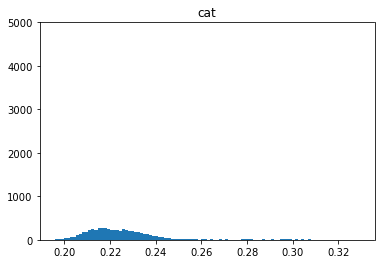

In [54]:
import matplotlib.pyplot as plt

plt.hist(sample_submission['Best Performance'],bins=100)
plt.ylim((0,5000))
plt.title('cat')
plt.show()

In [55]:
oof = pd.DataFrame({'id':X.index, 'catboost_oof': oof})
oof.to_csv("oof.csv", index=False)

In [56]:
print("Average cv roc auc score %0.3f ± %0.3f" % (np.mean(roc_auc), np.std(roc_auc)))
print("Average cv roc average precision %0.3f ± %0.3f" % (np.mean(average_precision), np.std(average_precision)))

print("Roc auc score OOF %0.3f" % roc_auc_score(y_true=y, y_score=oof.catboost_oof))
print("Average precision OOF %0.3f" % average_precision_score(y_true=y, y_score=oof.catboost_oof))

Average cv roc auc score 0.634 ± 0.062
Average cv roc average precision 0.257 ± 0.064
Roc auc score OOF 0.535
Average precision OOF 0.157


<AxesSubplot:xlabel='Importance', ylabel='Features'>

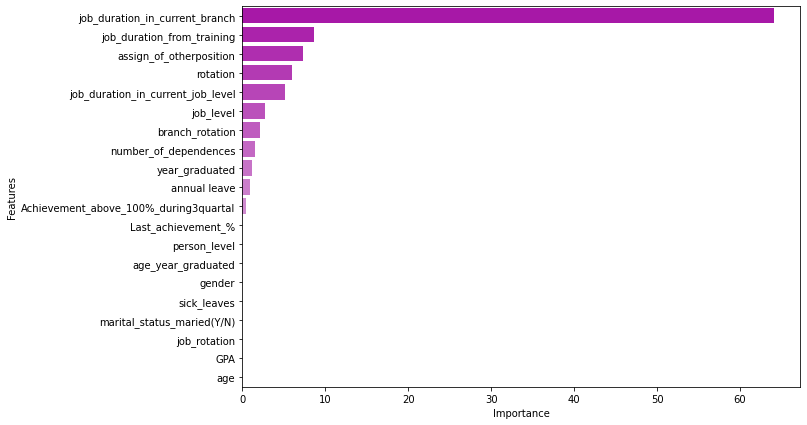

In [57]:
feature_dict = {'Features': catb.feature_names_, 'Importance': catb.feature_importances_}
feature_imp = pd.DataFrame(feature_dict).sort_values(by=['Importance'], ascending=False)

plt.figure(figsize=(10,7))
df_imp = feature_imp.head(20)
sns.barplot(y=df_imp['Features'], x=df_imp['Importance'], palette='light:m_r')

In [58]:
#catb.save_model('model_one')